In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, zero_one_loss, balanced_accuracy_score, average_precision_score
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import os
import pickle
import sys
import logging
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import backend

In [5]:
backend.set_image_data_format('channels_first')
# Loading the Base Model
from tensorflow.keras.applications.vgg16 import VGG16

image_input = Input(shape=(3,176,176))

base_model = VGG16(input_tensor =  image_input,
                   include_top = False, # Leave out the last fully connected layer
                   weights = 'imagenet')

#base_model.summary()

In [20]:
# Agrego capas al Base Model (EN PROCESO)
last_layer = base_model.get_layer("block4_pool").output
x = BatchNormalization(axis=3)(last_layer)
x = Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv1')(x)
x = 

In [8]:
##################################################################################################################
############################################ SEQUENTIAL ##########################################################
##################################################################################################################

In [2]:
backend.set_image_data_format('channels_first')

In [42]:
def get_vgg16():
    model = Sequential()

    # Encoder
    # Block 1
    model.add(BatchNormalization(axis=3, input_shape=(3, 176, 176)))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv1', input_shape=(80,120,3)))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))


    # Block 5
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv2'))

    # Decoder (probar tambien unpooling)
    # Block 6
    model.add(UpSampling2D((2, 2), name='block6_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv2'))

    # Block 7
    model.add(UpSampling2D((2, 2), name='block7_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv2'))

    # Block 8
    model.add(UpSampling2D((2, 2), name='block8_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv2'))

    # Block 9
    model.add(UpSampling2D((2, 2), name='block9_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv1'))
    model.add(BatchNormalization(axis=3))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv2'))

    # Output (probar activation = sigmoid en la ultima capa)
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(1, (1, 1), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block10_conv1'))
#    model.add(Conv2D(1, (1, 1), padding='same', activation='sigmoid', bias_regularizer=regularizers.l1(0.01), name='block10_conv1'))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mae', optimizer=sgd, metrics=['mse','acc'])
    #model.compile(loss='mae', optimizer=Adam(lr=0.001), metrics=['mse'])
    #model.compile(optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
    print(model.summary())

    return model

model = get_vgg16()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 3, 176, 176)       704       
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 176, 176)      1792      
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 176, 176)      704       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 176, 176)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 88, 88)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 64, 88, 88)        352       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 88, 88)      

In [43]:
X_train_dir = "X_train.npy"
X_val_dir   = "X_val.npy"
X_test_dir = "X_test.npy"
Y_train_dir = "Y_train.npy"
Y_val_dir   = "Y_val.npy"

X_train = np.load(X_train_dir)
X_val   = np.load(X_val_dir)
X_test = np.load(X_test_dir)
Y_train = np.load(Y_train_dir)
Y_val   = np.load(Y_val_dir)

print("X_train: %s" %str(X_train.shape))
print("X_val: %s" %str(X_val.shape))
print("X_test: %s" %str(X_test.shape))
print("Y_train: %s" %str(Y_train.shape))
print("Y_val: %s" %str(Y_val.shape))

X_train: (2050, 3, 176, 176)
X_val: (439, 3, 176, 176)
X_test: (439, 3, 176, 176)
Y_train: (2050, 176, 176)
Y_val: (439, 176, 176)


In [44]:
vgghist = model.fit(X_train, Y_train, validation_data = (X_val,Y_val), epochs = 20)

Epoch 1/20
65/65 [==============================] - 88s 1s/step - loss: 0.0470 - mse: 0.0462 - acc: 0.9097 - val_loss: 0.0246 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 2/20
65/65 [==============================] - 86s 1s/step - loss: 0.0213 - mse: 0.0169 - acc: 0.9828 - val_loss: 0.0250 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 3/20
65/65 [==============================] - 86s 1s/step - loss: 0.0235 - mse: 0.0191 - acc: 0.9806 - val_loss: 0.0245 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 4/20
65/65 [==============================] - 86s 1s/step - loss: 0.0228 - mse: 0.0185 - acc: 0.9813 - val_loss: 0.0252 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 5/20
65/65 [==============================] - 86s 1s/step - loss: 0.0227 - mse: 0.0183 - acc: 0.9814 - val_loss: 0.0244 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 6/20
65/65 [==============================] - 86s 1s/step - loss: 0.0244 - mse: 0.0201 - acc: 0.9797 - val_loss: 0.0251 - val_mse: 0.0207 - val_acc: 0.9795
Epoch 7/20
65/65 [==========

In [45]:
with open('trainHistoryDict_vgg16', 'wb') as file_pi:
    pickle.dump(vgghist.history, file_pi)

In [46]:
history = pickle.load( open( "trainHistoryDict_vgg16", "rb" ) )

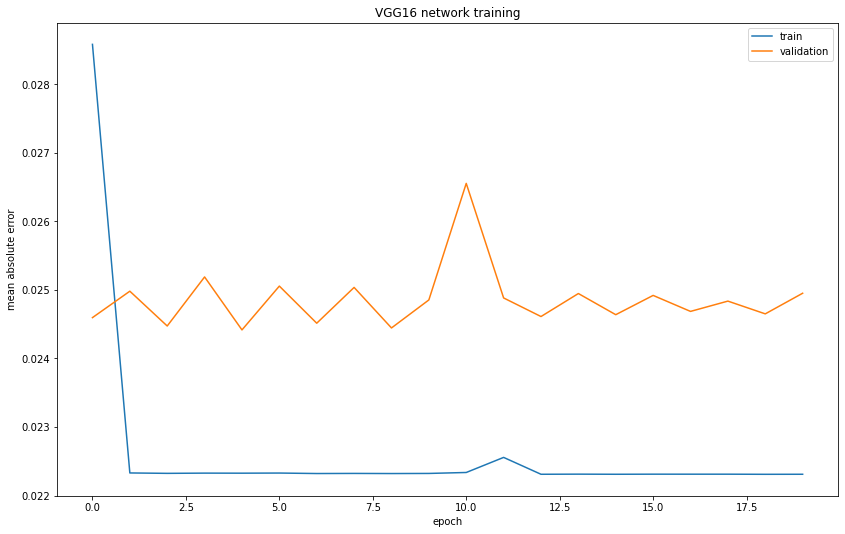

In [47]:
#print(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('VGG16 network training')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [48]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(439, 1, 176, 176)


In [49]:
# Para ver que valores hay y cuantas veces aparece c/u
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 13598462, 0.003810912: 1, 0.008395993: 1}


In [50]:
# Cargo en Y los valores reales de las matrices de tags, y le agrego una dim para coincidir con salida de la red
Y = np.load('Y_test.npy')
Y = np.expand_dims(Y,axis=1)
#print(Y.shape)

In [51]:
# Cuento la cantidad de unos y ceros en las matrices de tags
lluvias = np.where(Y==1)[0].size
nolluvias = np.where(Y==0)[0].size

print("Cantidad de unos que hay realmente: " + str(lluvias))
print("Cantidad de ceros que hay realmente: " + str(nolluvias))
total_real = lluvias+nolluvias
print("Total: " + str(total_real))

Cantidad de unos que hay realmente: 497011
Cantidad de ceros que hay realmente: 13101453
Total: 13598464


In [52]:
# Cuento la cantidad de unos y ceros en las matrices de prediccion
unos = np.where(y_pred == 1)[0].size
ceros = np.where(y_pred == 0)[0].size
otro_valor = np.where(y_pred != 0)[0].size

print("Cantidad de unos predichos: " + str(unos))
print("Cantidad de ceros predichos: " + str(ceros))
print("Cantidad de valores distintos de cero: " + str(otro_valor))
total_real = unos+ceros
print("Total: " + str(total_real))

Cantidad de unos predichos: 0
Cantidad de ceros predichos: 13598462
Cantidad de valores distintos de cero: 2
Total: 13598462


In [53]:
# creo que en Y_falses tengo la cantidad de veces que se predijo 0 y efectivamente habia un 0
Y_falses = y_pred[Y==0]
Y_trues = y_pred[Y==1]
print(Y_falses.shape)
print(Y_trues.shape)

(13101453,)
(497011,)


In [37]:
# CURVA ROC
def roc_curve(Y, y_pred):
    fpr, tpr, thresholds = roc_curve(Y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(14,14))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")

In [42]:
#    CURVA PRECISION-RECALL

def pr_curve(Y, y_pred):
    precision, recall, _ = precision_recall_curve(Y, y_pred)
    average_precision = average_precision_score(Y, y_pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.savefig("./pr_curve.png")

In [244]:
pr_curve(Y,y_pred) # Genera la curva Precision Recall

In [33]:
439*176*176

13598464

In [41]:
from sklearn import metrics
#                  1      0
#y_pred(1)         TP     FP
#y_pred(0)         FN     TN

print("TP: %d" %(np.where(y_pred == 1)[0].size))

TypeError: confusion_matrix() got an unexpected keyword argument 'y_type'